In [39]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My\ Drive/Colab\ Notebooks/pytorch-unet-1-master

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive/Colab Notebooks/pytorch-unet-1-master


In [12]:
# https://github.com/usuyama/pytorch-unet
%matplotlib inline
%load_ext autoreload
%autoreload 2
import cv2 as cv
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import helper
import simulation

from PIL import Image

import time

grayImages = np.zeros((20, 584, 565))
groundTruth = np.zeros((20, 584, 565))
for i in range(21,41):
    mask = np.array(Image.open(f"../retina-unet-master/Training/background_masks/{i}_training_mask.gif"))/255
    grayImages[i - 21,:,:] = cv.imread(f"../retina-unet-master/Training/original_retinal_images/{i}_training.tif")[:,:,1] * mask
    groundTruth[i - 21,:,:] = 1 - np.array(Image.open(f"../retina-unet-master/Training/blood_vessel_segmentation_masks/{i}_manual1.gif"))/255

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
claheImages = np.zeros_like(grayImages)
clahe = cv.createCLAHE(clipLimit = 2, tileGridSize = (8,8))
for i in range(20):
    claheImages[i,:,:] = clahe.apply(grayImages[i,:,:].astype(np.uint8))

In [ ]:
# https://www.pyimagesearch.com/2015/10/05/opencv-gamma-correction/
gammaImages = np.zeros_like(grayImages)
def adjust_gamma(image, gamma=1.0):
    # build a lookup table mapping the pixel values [0, 255] to
    # their adjusted gamma values
    invGamma = 1.0 / gamma
    maxInt = image.max()
    table = np.array([((i / maxInt) ** invGamma) * maxInt 
                      for i in np.arange(0, 256)]).astype("uint8")

    # apply gamma correction using the lookup table
    return cv.LUT(image.astype(np.uint8), table)
for i in range(20):
    gammaImages[i,:,:] = adjust_gamma(claheImages[i, :, :], 1.2)

In [ ]:
stImages = np.zeros_like(grayImages)
for i in range(20):
    stImages[i,:,:] = (gammaImages[i,:,:] - gammaImages[i,:,:].min())/(gammaImages[i,:,:].max() - gammaImages[i,:,:].min())

In [ ]:
# def gen_patches(img, truth, num):
#     patchesData = np.zeros((num,48,48)) 
#     patchesTruth = np.zeros((num,48,48))
#     range0 = img.shape[0] - 48
#     range1 = img.shape[1] - 48
#     pts = list(zip((np.random.rand(num) * range0).astype(int), 
#                     (np.random.rand(num) * range1).astype(int)))
#     for i in range(num):
#         x, y = pts[i]
#         patchesData[i,:,:] = img[x:x+48, y:y+48]
#         patchesTruth[i,:,:] = truth[x:x+48, y:y+48]
#     return patchesData, patchesTruth
def gen_patches(img, truth, num):
    patchesData = np.zeros((num ** 2,224,224)) 
    patchesTruth = np.zeros((num ** 2,224,224))
    range0 = img.shape[0] - 224
    range1 = img.shape[1] - 224
    xrange, yrange = np.arange(0,range0, range0//num + 1), np.arange(0,range1, range1//num + 1)
    i = 0
    for x in xrange:
        for y in yrange:
            patchesData[i,:,:] = img[x:x+224, y:y+224]
            patchesTruth[i,:,:] = truth[x:x+224, y:y+224]
            i += 1
    return patchesData, patchesTruth

In [ ]:
def dataShuffle(a,b):
    seed = int(time.time())
    np.random.seed(seed)
    np.random.shuffle(a)
    np.random.seed(seed)
    np.random.shuffle(b)
    return a,b
def augmentation(n):
    pn = 20
    x, y = np.zeros((n**2*pn,224,224)),np.zeros((n**2*pn,224,224))
    for i in range(pn):
        x[i*n**2:(i+1)*n**2,:,:], y[i*n**2:(i+1)*n**2,:,:] = gen_patches(stImages[i,:,:], groundTruth[i,:,:], n)
    return x,y
rate = 10
train_x, train_y1 = dataShuffle(*augmentation(rate))
test, gtruth1 = gen_patches(stImages[0,:,:], groundTruth[0,:,:], 10)

In [ ]:
bs, h, w = train_y1.shape
train_y = np.zeros((bs, 2, h, w))
train_y[:,0,:,:][train_y1 == 0] = 1
train_y[:,1,:,:][train_y1 == 1] = 1
bs, h, w = gtruth1.shape
gtruth = np.zeros((bs, 2, h, w))
gtruth[:,0,:,:][gtruth1 == 0] = 1
gtruth[:,1,:,:][gtruth1 == 1] = 1
del train_y1, gtruth1

(3, 224, 224)
0.00816326530612245 1.0
(3, 224, 224)
0.0 1.0


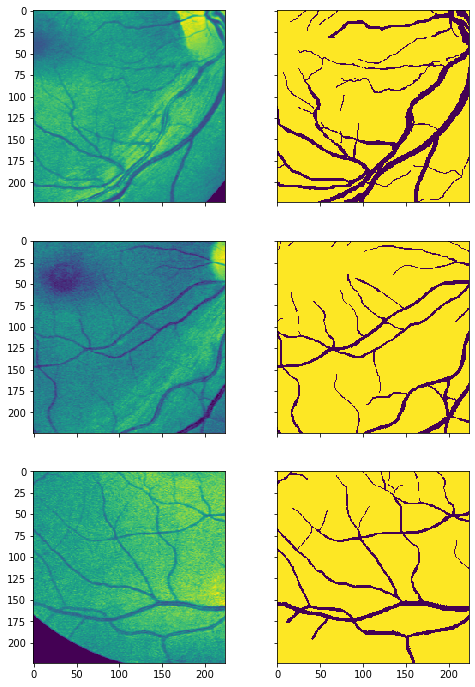

In [19]:
# Generate some random images
input_images, target_masks = train_x[12:15,:,:], train_y[12:15,1,:,:]


for x in [input_images, target_masks]:
    print(x.shape)
    print(x.min(), x.max())

# Change channel-order and make 3 channels for matplot
input_images_rgb = [x for x in input_images]

# Map each channel (i.e. class) to each color
target_masks_rgb = [x for x in target_masks]

# Left: Input image, Right: Target mask
helper.plot_side_by_side([input_images_rgb, target_masks_rgb])

In [20]:
device = torch.device("cuda:0")
tensor_x, tensor_y = torch.tensor(train_x, device = device).float(), torch.tensor(train_y, device = device).float()
tensor_vx, tensor_vy = torch.tensor(test, device = device).float(), torch.tensor(gtruth, device = device).float()
train_set = torch.utils.data.TensorDataset(tensor_x.unsqueeze(1), tensor_y)
val_set = torch.utils.data.TensorDataset(tensor_vx.unsqueeze(1), tensor_vy)

image_datasets = {
    'train': train_set, 'val': val_set
}

batch_size = 32

dataloaders = {
    'train': torch.utils.data.DataLoader(train_set, batch_size=batch_size, num_workers=0),
    'val': torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=0)
}

dataset_sizes = {
    x: len(image_datasets[x]) for x in image_datasets.keys()
}

dataset_sizes

{'train': 2000, 'val': 100}

In [21]:
inputs, masks = next(iter(dataloaders['train']))
print(inputs.shape, masks.shape)

torch.Size([32, 1, 224, 224]) torch.Size([32, 2, 224, 224])


In [ ]:
from torchvision import models

base_model = models.resnet18(pretrained=False)
    
# list(base_model.children())

In [23]:
# check keras-like model summary using torchsummary
import torch
from torchsummary import summary

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
base_model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3,bias=False)
base_model = base_model.to(device)

summary(base_model, input_size=(1, 48, 48))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 24, 24]           3,136
       BatchNorm2d-2           [-1, 64, 24, 24]             128
              ReLU-3           [-1, 64, 24, 24]               0
         MaxPool2d-4           [-1, 64, 12, 12]               0
            Conv2d-5           [-1, 64, 12, 12]          36,864
       BatchNorm2d-6           [-1, 64, 12, 12]             128
              ReLU-7           [-1, 64, 12, 12]               0
            Conv2d-8           [-1, 64, 12, 12]          36,864
       BatchNorm2d-9           [-1, 64, 12, 12]             128
             ReLU-10           [-1, 64, 12, 12]               0
       BasicBlock-11           [-1, 64, 12, 12]               0
           Conv2d-12           [-1, 64, 12, 12]          36,864
      BatchNorm2d-13           [-1, 64, 12, 12]             128
             ReLU-14           [-1, 64,

In [ ]:
class MyResNet(models.ResNet):
    def __init__(self):
        super(MyResNet, self).__init__(torchvision.models.resnet.BasicBlock, [2, 2, 2, 2], num_classes=2)
        self.conv1 = torch.nn.Conv2d(1, 64, 
            kernel_size=(7, 7), 
            stride=(2, 2), 
            padding=(3, 3), bias=False)
        
x = MyResNet()
    # def forward(self, x):
    #     return torch.softmax(
    #         super(MyResNet, self).forward(x), dim=-1)

In [ ]:
# list(x.children())

In [ ]:
import torch
import torch.nn as nn

def convrelu(in_channels, out_channels, kernel, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
        nn.ReLU(inplace=True),
    )

class ResNetUNet(nn.Module):

    def __init__(self, n_class):
        super().__init__()
        
        # self.base_model = MyResNet()
        
        
        self.base_layers = list(self.base_model.children())             
        
        self.layer0 = nn.Sequential(*self.base_layers[:3]) # size=(N, 64, x.H/2, x.W/2)
        self.layer0_1x1 = convrelu(64, 64, 1, 0)
        self.layer1 = nn.Sequential(*self.base_layers[3:5]) # size=(N, 64, x.H/4, x.W/4)        
        self.layer1_1x1 = convrelu(64, 64, 1, 0)       
        self.layer2 = self.base_layers[5]  # size=(N, 128, x.H/8, x.W/8)        
        self.layer2_1x1 = convrelu(128, 128, 1, 0)  
        self.layer3 = self.base_layers[6]  # size=(N, 256, x.H/16, x.W/16)        
        self.layer3_1x1 = convrelu(256, 256, 1, 0)  
        self.layer4 = self.base_layers[7]  # size=(N, 512, x.H/32, x.W/32)
        self.layer4_1x1 = convrelu(512, 512, 1, 0)  
        
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        
        self.conv_up3 = convrelu(256 + 512, 512, 3, 1)
        self.conv_up2 = convrelu(128 + 512, 256, 3, 1)
        self.conv_up1 = convrelu(64 + 256, 256, 3, 1)
        self.conv_up0 = convrelu(64 + 256, 128, 3, 1)
        
        self.conv_original_size0 = convrelu(1, 64, 3, 1)
        self.conv_original_size1 = convrelu(64, 64, 3, 1)
        self.conv_original_size2 = convrelu(64 + 128, 64, 3, 1)
        
        self.conv_last = nn.Conv2d(64, n_class, 1)
        
    def forward(self, input):
        x_original = self.conv_original_size0(input)
        x_original = self.conv_original_size1(x_original)
        
        layer0 = self.layer0(input)           
        layer1 = self.layer1(layer0)
        layer2 = self.layer2(layer1)
        layer3 = self.layer3(layer2)        
        layer4 = self.layer4(layer3)
        
        layer4 = self.layer4_1x1(layer4)
        x = self.upsample(layer4)
        layer3 = self.layer3_1x1(layer3)
        x = torch.cat([x, layer3], dim=1)
        x = self.conv_up3(x)
 
        x = self.upsample(x)
        layer2 = self.layer2_1x1(layer2)
        x = torch.cat([x, layer2], dim=1)
        x = self.conv_up2(x)

        x = self.upsample(x)
        layer1 = self.layer1_1x1(layer1)
        x = torch.cat([x, layer1], dim=1)
        x = self.conv_up1(x)

        x = self.upsample(x)
        layer0 = self.layer0_1x1(layer0)
        x = torch.cat([x, layer0], dim=1)
        x = self.conv_up0(x)
        
        x = self.upsample(x)
        x = torch.cat([x, x_original], dim=1)
        x = self.conv_original_size2(x)        
        
        out = self.conv_last(x)        
        
        return out

In [ ]:
class MyUnet(torch.nn.Module):
    def __init__(self):
        super(MyUnet, self).__init__()
        self.conv11 = torch.nn.Conv2d(1, 32, 3, padding = 1)
        self.conv12 = torch.nn.Conv2d(32, 32, 3, padding = 1)
        
        self.conv21 = torch.nn.Conv2d(32, 64, 3, padding = 1)
        self.conv22 = torch.nn.Conv2d(64, 64, 3, padding = 1)
        
        self.conv31 = torch.nn.Conv2d(64, 128, 3, padding = 1)
        self.conv32 = torch.nn.Conv2d(128, 128, 3, padding = 1)
        
        self.pool1 = torch.nn.MaxPool2d(2)
        self.up1 = torch.nn.UpsamplingBilinear2d(scale_factor=2)
        
        self.conv41 = torch.nn.Conv2d(128 + 64, 64, 3, padding = 1)
        self.conv42 = torch.nn.Conv2d(64, 64, 3, padding = 1)
        
        self.conv51 = torch.nn.Conv2d(64 + 32, 32, 3, padding = 1)
        self.conv52 = torch.nn.Conv2d(32, 32, 3, padding = 1)
        
        self.conv6 = torch.nn.Conv2d(32, 2, 1)
        self.dropout = torch.nn.Dropout(0.2)
        
    def forward(self, x):
        ##########################
        #1 channel to 32, x.size(48,48)
        x = F.relu(self.conv11(x))
        x = self.dropout(x)
        x = F.relu(self.conv12(x))
        new_x1 = x.clone()
        # print(x.shape, 'conv1')
        x = self.pool1(x)
        ##########################
        #32 channel to 64, x.size(24,24)
        x = F.relu(self.conv21(x))
        x = self.dropout(x)
        x = F.relu(self.conv22(x))
        new_x2 = x.clone()
        # print(x.shape, 'conv2')
        x = self.pool1(x)
        ##########################
        #64 channel to 128, x.size(12,12)
        x = F.relu(self.conv31(x))
        x = self.dropout(x)
        x = F.relu(self.conv32(x))
        # print(x.shape, 'conv3')
        ##########################
        x = self.up1(x) # 24 * 24
        # print(x.shape)
        x = torch.cat((new_x2, x), axis = 1)
        x = F.relu(self.conv41(x))
        x = self.dropout(x)
        x = F.relu(self.conv42(x))
        ##########################
        x = self.up1(x) # 48 * 48
        x = torch.cat((new_x1, x), axis = 1)
        x = F.relu(self.conv51(x))
        x = self.dropout(x)
        x = F.relu(self.conv52(x))
        ##########################
        x = F.relu(self.conv6(x)) # 48 * 48
        ori_shape = x.shape
        x = x.reshape(x.shape[0],2,-1)

        x = F.softmax(x, dim = -1)
        return x.reshape(ori_shape)

In [28]:
# check keras-like model summary using torchsummary

from torchsummary import summary

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ResNetUNet(2)
# model = MyUnet()
model = model.to(device)

summary(model, input_size=(1, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]             640
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
            Conv2d-5         [-1, 64, 112, 112]           3,136
            Conv2d-6         [-1, 64, 112, 112]           3,136
       BatchNorm2d-7         [-1, 64, 112, 112]             128
       BatchNorm2d-8         [-1, 64, 112, 112]             128
              ReLU-9         [-1, 64, 112, 112]               0
             ReLU-10         [-1, 64, 112, 112]               0
        MaxPool2d-11           [-1, 64, 56, 56]               0
        MaxPool2d-12           [-1, 64, 56, 56]               0
           Conv2d-13           [-1, 64, 56, 56]          36,864
           Conv2d-14           [-1, 64,

In [ ]:
from collections import defaultdict
import torch.nn.functional as F
import torch
from loss import dice_loss

def calc_loss(pred, target, metrics, bce_weight=0.5):
    bce = F.binary_cross_entropy_with_logits(pred, target)
        
    pred = torch.sigmoid(pred)
    dice = dice_loss(pred, target)
    
    loss = bce * bce_weight + dice * (1 - bce_weight)
    
    metrics['bce'] += bce.data.cpu().numpy() * target.size(0)
    metrics['dice'] += dice.data.cpu().numpy() * target.size(0)
    metrics['loss'] += loss.data.cpu().numpy() * target.size(0)
    
    return loss

def print_metrics(metrics, epoch_samples, phase):    
    outputs = []
    for k in metrics.keys():
        outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))
        
    print("{}: {}".format(phase, ", ".join(outputs)))    

def train_model(model, optimizer, scheduler, num_epochs=25):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10

    for epoch in range(1, num_epochs+1):
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-' * 10)
        
        since = time.time()

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            metrics = defaultdict(float)
            epoch_samples = 0
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)             

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = calc_loss(outputs, labels, metrics)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                # statistics
                epoch_samples += inputs.size(0)
            if phase == 'train':
                scheduler.step()
                for param_group in optimizer.param_groups:
                    print("LR", param_group['lr'])
                    
            print_metrics(metrics, epoch_samples, phase)
            epoch_loss = metrics['loss'] / epoch_samples

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                print("saving best model")
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        time_elapsed = time.time() - since
        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
            
    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [31]:
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

num_class = 2
model = ResNetUNet(num_class).to(device)

# freeze backbone layers
# Comment out to finetune further
# for l in model.base_layers:
#     for param in l.parameters():
#         param.requires_grad = False

optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)        
        
model = train_model(model, optimizer_ft, exp_lr_scheduler, num_epochs=100)

Epoch 1/100
----------
LR 0.0001
train: bce: 0.358302, dice: 0.460162, loss: 0.409232
val: bce: 0.226116, dice: 0.373380, loss: 0.299748
saving best model
0m 28s
Epoch 2/100
----------
LR 0.0001
train: bce: 0.221957, dice: 0.276155, loss: 0.249056
val: bce: 0.137350, dice: 0.209916, loss: 0.173633
saving best model
0m 28s
Epoch 3/100
----------
LR 0.0001
train: bce: 0.174126, dice: 0.207279, loss: 0.190703
val: bce: 0.121944, dice: 0.175440, loss: 0.148692
saving best model
0m 28s
Epoch 4/100
----------
LR 0.0001
train: bce: 0.158381, dice: 0.183909, loss: 0.171145
val: bce: 0.111040, dice: 0.158157, loss: 0.134598
saving best model
0m 28s
Epoch 5/100
----------
LR 0.0001
train: bce: 0.149687, dice: 0.171226, loss: 0.160457
val: bce: 0.105706, dice: 0.152063, loss: 0.128885
saving best model
0m 28s
Epoch 6/100
----------
LR 0.0001
train: bce: 0.145414, dice: 0.164420, loss: 0.154917
val: bce: 0.101019, dice: 0.146400, loss: 0.123710
saving best model
0m 28s
Epoch 7/100
----------
LR 0.

In [34]:
#### prediction

import math

model.eval()   # Set model to evaluate mode

test_loader = dataloaders['val']
        
inputs, labels = next(iter(test_loader))
inputs = inputs.to(device)
print('inputs',inputs.shape)
labels = labels.to(device)
print('labels',labels.shape)
pred = model(inputs)
print('pred',pred.shape)
pred = torch.sigmoid(pred)
pred = pred.data.cpu().numpy()
print(pred.shape)

# Change channel-order and make 3 channels for matplot
input_images_rgb = [i for i in inputs.cpu()[3:4]]

# Map each channel (i.e. class) to each color
target_masks_rgb = [i for i in labels.cpu().numpy()[3:4]]
pred_rgb = [i[0,:,:] for i in pred[3:4]]

# helper.plot_side_by_side([input_images_rgb, target_masks_rgb, pred_rgb])
pred[1,0,:,:]

inputs torch.Size([32, 1, 224, 224])
labels torch.Size([32, 2, 224, 224])
pred torch.Size([32, 2, 224, 224])
(32, 2, 224, 224)


array([[3.25896479e-02, 4.06411942e-03, 2.24591233e-03, ...,
        1.62441134e-02, 1.98333245e-02, 7.80680925e-02],
       [4.02064668e-03, 2.33378058e-04, 1.10567831e-04, ...,
        2.24745064e-03, 2.76417076e-03, 2.12055221e-02],
       [1.62371283e-03, 1.05134917e-04, 5.80464693e-05, ...,
        1.87495176e-03, 2.38592876e-03, 1.81966685e-02],
       ...,
       [2.46053515e-03, 2.33508705e-04, 1.32132802e-04, ...,
        1.01328862e-03, 1.46812247e-03, 1.29374256e-02],
       [5.12465788e-03, 7.36637623e-04, 5.40565175e-04, ...,
        3.56045808e-03, 5.30485809e-03, 3.10700238e-02],
       [2.33365167e-02, 5.78300143e-03, 4.63036867e-03, ...,
        1.90590005e-02, 3.08575109e-02, 1.13013454e-01]], dtype=float32)

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


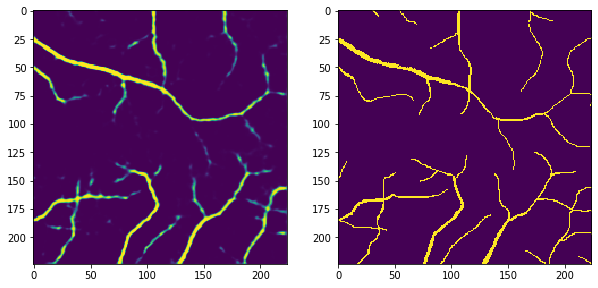

In [40]:
plt.figure(figsize = (10,10))
plt.subplot(121),plt.imshow(pred[1,0,:,:])
plt.subplot(122),plt.imshow(labels.cpu().numpy()[1,0,:,:])

for i in range(32):
    newImage = np.zeros((224,448))
    l = (pred[i,0,:,:] - pred[i,0,:,:].min())/(pred[i,0,:,:].max() - pred[i,0,:,:].min())
    r = labels.cpu().numpy()[i,0,:,:] * 255
    newImage = np.concatenate((l * 255, r), axis = 1)
    cv.imwrite(f"/gdrive/My Drive/Colab Notebooks/retina-unet-master/new_result/{i + 1}output.jpg", newImage)

In [ ]:
src = (pred[1,0,:,:] - pred[1,0,:,:].min())/(pred[1,0,:,:].max() - pred[1,0,:,:].min())
dst = cv.threshold(src, 0.2, 255, cv.THRESH_BINARY)[1]
plt.imshow(dst, cmap = 'binary')
kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (3,3))
# dst = cv.dilate(dst, kernel, iterations = 2)
# dst = cv.erode(dst, kernel, iterations = 2)

# dst = cv.erode(dst, kernel, iterations = 5)
# dst = cv.morphologyEx(dst, cv.MORPH_OPEN, None, iterations = 1)
# dst = cv.morphologyEx(dst, cv.MORPH_OPEN, (1,11), iterations = 5)

In [ ]:
# plt.imshow(dst, cmap = 'binary')

In [68]:
class Maze:
    def __init__(self,x):
        if x < 0:
            raise MazeError("Input does not")
        if x > 10:
            raise MazeError("123978")
class MazeError(Exception):
    def __init__(self,  message):
        self.message = message

NameError: name 'self' is not defined

In [67]:
maze = Maze(-1)

MazeError: Input does not

In [65]:
maze.MazeError

__main__.Maze.MazeError

In [75]:
x = 'asdfoijo'
if not x.isdigit():
    raise ValueError(f"invalid literal for int() with base 10: '{x}'")

ValueError: invalid literal for int() with base 10: 'asdfoijo'

In [77]:
np.arange(5)

NameError: name 'np' is not defined

In [79]:
[123][1]

IndexError: list index out of range

In [81]:
a = '      sd Trainingfhi       '
a.replace('\t','').replace(' ','')

'sdTrainingfhi'